In [1043]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

### Download sequences

In [64]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0    272      0 --:--:-- --:--:-- --:--:--   272
100 31.3M  100 31.3M    0     0  2307k      0  0:00:13  0:00:13 --:--:-- 4148k
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   216  100   216    0     0    273      0 --:--:-- --:--:-- --:--:--   273
100 12.2M  100 12.2M    0     0  4054k      0  0:00:03  0:00:03 --:--:-- 7927k
+ bash scripts/

In [1044]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

In [1045]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [1046]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [1047]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [1048]:
df.reason.value_counts()

N                             255781
X                             184469
A[B.1.1.7]                     35809
A[B.1.617.2]                   35301
Y                              23484
                               ...  
A[E484E/N501N/P681R]               0
A[E484K/N501Y/P681R]               0
A[E484E/N501N/P681P]               0
A[N501Y/E484K]                     0
A[KONTAKTMITENGL.MUTATION]         0
Name: reason, Length: 205, dtype: int64

In [1049]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d.lineage = d.lineage.cat.add_categories(['Other'])
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Other"
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage.cat.remove_unused_categories(), dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other
bundesland        date                                       
Baden-Württemberg 2021-11-01     0       0     0     0    142
                  2021-11-02     0       0     0     0    350
                  2021-11-03     0       0     0     0    704
                  2021-11-04     0       0     0     0   1044
                  2021-11-05     0       0     0     0   1210
...                            ...     ...   ...   ...    ...
Thüringen         2022-02-02     1       1     0     0      1
                  2022-02-03     1       1     0     0      0
                  2022-02-04     0       0     0     0      0
                  2022-02-05     0       0     0     0      0
                  2022-02-08     0       0     0     0      0

[1568 rows x 5 columns]

In [1050]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [1051]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [1052]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [1053]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-21   
                                    2020-03-13  2020-03-19   
                                    2020-03-16  2020-03-19   
            A35-A59      M          2020-03-16  2020-03-14   
...                                                    ...   
16077       A35-A59      W          2022-02-10  2022-02-10   
            unbekannt    W          2022-02-10  2022-02-10   
            A05-A14      W          2022-02-10  2022-02-10   
            A15-A34      W          2022-02-10  2022-02-10   
            A60-A79      W          2022-02-10  2022-02-10   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
            A35-A59      M          2020-03-16                     1   
...                                                              ...   
16077       A35-A59      W          2022-02-10                     0   
            unbekannt    W          2022-02-10                     0   
            A05-A14      W          2022-02-10                     0   
            A15-A34      W          2022-02-10                     0   
            A60-A79      W          2022-02-10                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
            A35-A59      M          2020-03-16          0              -9   
...                                                   ...             ...   
16077       A35-A59      W          2022-02-10          1              -9   
            unbekannt    W          2022-02-10          1              -9   
            A05-A14      W          2022-02-10          1              -9   
            A15-A34      W          2022-02-10          1              -9   
            A60-A79      W          2022-02-10          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
            A35-A59      M          2020-03-16           0           1   
...                                                    ...         ...   
16077       A35-A59      W          2022-02-10          -9          27   
            unbekannt    W          2022-02-10          -9           1   
            A05-A14      W          2022-02-10          -9           3   
            A15-A34      W          2022-02-10          -9          13   
            A60-A79      W          2022-02-10          -9           5   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

In [1054]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2021-12-27":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

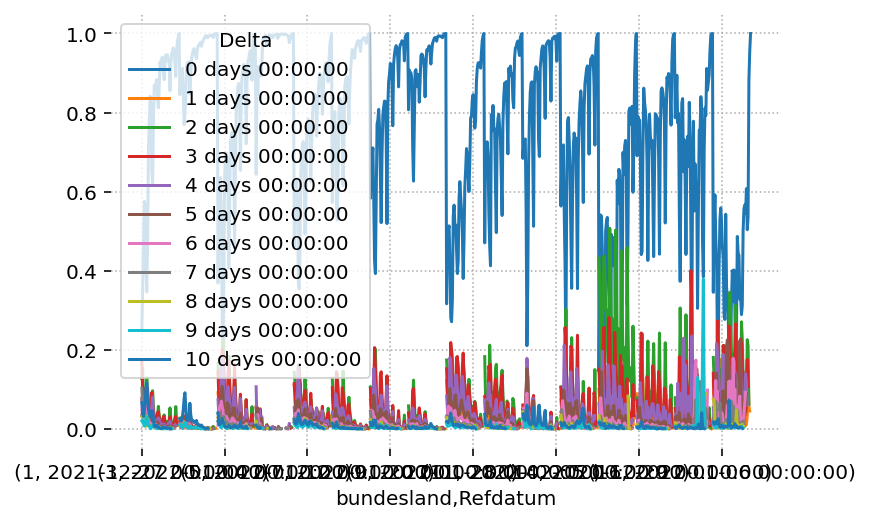

In [1055]:
f.plot()

In [1056]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [1057]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [1058]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Mon             0.737303         0.772110         0.823573         0.879127   
Tue             0.819974         0.844394         0.888011         0.903828   
Wed             0.842687         0.873510         0.888062         0.908087   
Thu             0.876820         0.878014         0.898778         0.915544   
Fri             0.849622         0.866773         0.886853         0.909733   
Sat             0.775354         0.791916         0.832386         0.884838   
Sun             0.734218         0.759938         0.831045         0.880364   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Mon             0.899190         0.913008         0.924525         0.949175   
Tue             0.920077         0.932776         0.951971         0.966439   
Wed             0.926838         0.948064         0.963170         0.974526   
Thu             0.935973         0.954987         0.967697         0.976512   
Fri             0.935952         0.954393         0.967585         0.971217   
Sat             0.918281         0.943112         0.951469         0.955968   
Sun             0.922492         0.933908         0.941238         0.933001   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Mon             0.960183         0.969577               1.0  
Tue             0.975557         0.982435               1.0  
Wed             0.982758         0.984754               1.0  
Thu             0.980194         0.982296               1.0  
Fri             0.974182         0.976215               1.0  
Sat             0.948627         0.959716               1.0  
Sun             0.956504         0.965680               1.0

In [1059]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [1060]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [1061]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.997685  0.996280  0.994253  0.986317  0.972155   
Bayern                  0.989955  0.982036  0.972505  0.947551  0.916095   
Berlin                  0.985753  0.983553  0.970055  0.913236  0.865968   
Brandenburg             0.992140  0.987422  0.977890  0.959887  0.912427   
Bremen                  1.000000  0.997850  0.995005  0.993879  0.993134   
Hamburg                 0.981553  0.977948  0.970960  0.945864  0.945724   
Hessen                  0.997252  0.996397  0.993115  0.982687  0.973561   
Mecklenburg-Vorpommern  0.993490  0.991245  0.982628  0.976559  0.953243   
Niedersachsen           0.992781  0.988496  0.977854  0.957021  0.906657   
Nordrhein-Westfalen     0.987238  0.982205  0.970456  0.941516  0.904583   
Rheinland-Pfalz         0.994668  0.993489  0.984547  0.968043  0.941057   
Saarland                0.993975  0.993899  0.987907  0.984846  0.963302   
Sachsen                 0.996856  0.997140  0.991751  0.983687  0.970894   
Sachsen-Anhalt          0.998461  0.995906  0.972347  0.924196  0.851620   
Schleswig-Holstein      0.982758  0.976512  0.967585  0.943112  0.922492   
Thüringen               0.993406  0.986334  0.975164  0.909810  0.904850   

                               5         6         7         8  
Baden-Württemberg       0.966922  0.975114  0.963811  0.950669  
Bayern                  0.853708  0.828423  0.767578  0.726040  
Berlin                  0.926683  0.927501  0.927130  0.922170  
Brandenburg             0.911951  0.903408  0.869844  0.840726  
Bremen                  0.949552  0.973661  0.959439  0.985197  
Hamburg                 0.949789  0.964465  0.961658  0.963685  
Hessen                  0.952817  0.951131  0.931708  0.922402  
Mecklenburg-Vorpommern  0.882226  0.890938  0.703786  0.673560  
Niedersachsen           0.883166  0.880344  0.849805  0.831726  
Nordrhein-Westfalen     0.887242  0.882315  0.851622  0.828797  
Rheinland-Pfalz         0.929582  0.924697  0.897323  0.888929  
Saarland                0.888396  0.916137  0.875795  0.871270  
Sachsen                 0.955992  0.949229  0.895188  0.834200  
Sachsen-Anhalt          0.897828  0.884706  0.804194  0.810327  
Schleswig-Holstein      0.879127  0.888011  0.873510  0.876820  
Thüringen               0.837440  0.777413  0.669136  0.523891

In [1062]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [1063]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2140        2958        4431        4622   
Bayern                        5939        7030        9170        8934   
Berlin                        1261        1311        1479        1430   
Brandenburg                    808         978        1071        1061   
Bremen                          79          89          69          62   
Hamburg                        309         441         545         532   
Hessen                        1186        1591        1716        1582   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1185        1453        1674        1369   
Nordrhein-Westfalen           2510        3361        4298        4373   
Rheinland-Pfalz                642         990        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2834        3666        3469        3304   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             337         390         366         354   
Thüringen                     1785        1391        1479        1567   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5070        4130        2277        4416   
Bayern                        9236        8783        7210        9310   
Berlin                        1455         906         699        2212   
Brandenburg                   1184        1117         971        1253   
Bremen                          55          55          31          60   
Hamburg                        563         470         410         469   
Hessen                        1686        1319        1091        1470   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1397        1165         843        1621   
Nordrhein-Westfalen           4070        3719        2855        4325   
Rheinland-Pfalz               1027         809         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3459        3184        2642        4410   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             435         382         298         448   
Thüringen                     1430        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-02-01  2022-02-02  \
bundesland                                      ...                           
Baden-Württemberg             7143        7759  ...       29391       31775   
Bayern                       11220       12117  ...       40298       44632   
Berlin                        1912        2347  ...       14648       13354   
Brandenburg                   1493        1682  ...        8574        8393   
Bremen                         143          95  ...        1331        1681   
Hamburg                        532         578  ...        6994        6385   
Hessen                        1791        2066  ...       18010       19284   
Mecklenburg-Vorpommern         596         468  ...        3766        3270   
Niedersachsen                 1754        2163  ...       16742       17529   
Nordrhein-Westfalen           5241        5410  ...       46074       47976   
Rheinland-Pfalz               1139        1329  ...        9245        8901   
Saarland                       273         301  ...        2318        2769   
Sachsen                       5781        5975  ...        8994        7258   
Sachsen-Anhalt                1019        1178  ...        4691        5064   
Schleswig-Holstein             486         542  ...        4777       

In [1064]:
cases_land.sum(0)

Refdatum
2021-11-01     22207
2021-11-02     27056
2021-11-03     32223
2021-11-04     31554
2021-11-05     32525
               ...  
2022-02-06     81271
2022-02-07    166750
2022-02-08    224647
2022-02-09    216542
2022-02-10    159548
Length: 102, dtype: int64

In [1065]:
clip = 1
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2140        2958        4431        4622   
Bayern                        5939        7030        9170        8934   
Berlin                        1261        1311        1479        1430   
Brandenburg                    808         978        1071        1061   
Bremen                          79          89          69          62   
Hamburg                        309         441         545         532   
Hessen                        1186        1591        1716        1582   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1185        1453        1674        1369   
Nordrhein-Westfalen           2510        3361        4298        4373   
Rheinland-Pfalz                642         990        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2834        3666        3469        3304   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             337         390         366         354   
Thüringen                     1785        1391        1479        1567   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5070        4130        2277        4416   
Bayern                        9236        8783        7210        9310   
Berlin                        1455         906         699        2212   
Brandenburg                   1184        1117         971        1253   
Bremen                          55          55          31          60   
Hamburg                        563         470         410         469   
Hessen                        1686        1319        1091        1470   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1397        1165         843        1621   
Nordrhein-Westfalen           4070        3719        2855        4325   
Rheinland-Pfalz               1027         809         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3459        3184        2642        4410   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             435         382         298         448   
Thüringen                     1430        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-01-31  2022-02-01  \
bundesland                                      ...                           
Baden-Württemberg             7143        7759  ...       20154       29391   
Bayern                       11220       12117  ...       25092       40298   
Berlin                        1912        2347  ...       12299       14648   
Brandenburg                   1493        1682  ...        6143        8574   
Bremen                         143          95  ...        1546        1331   
Hamburg                        532         578  ...        5305        6994   
Hessen                        1791        2066  ...       16370       18010   
Mecklenburg-Vorpommern         596         468  ...        1958        3766   
Niedersachsen                 1754        2163  ...       11239       16742   
Nordrhein-Westfalen           5241        5410  ...       36940       46074   
Rheinland-Pfalz               1139        1329  ...        7483        9245   
Saarland                       273         301  ...        1165        2318   
Sachsen                       5781        5975  ...        5123        8994   
Sachsen-Anhalt                1019        1178  ...        2843        4691   
Schleswig-Holstein             486         542  ...        3716       

In [1066]:
C = cases_land.values

In [1067]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [1068]:
from genomicsurveillance.misc import fused_basis
B0 = fused_basis(C.shape[1]+clip, inc=10, fuse=5) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 

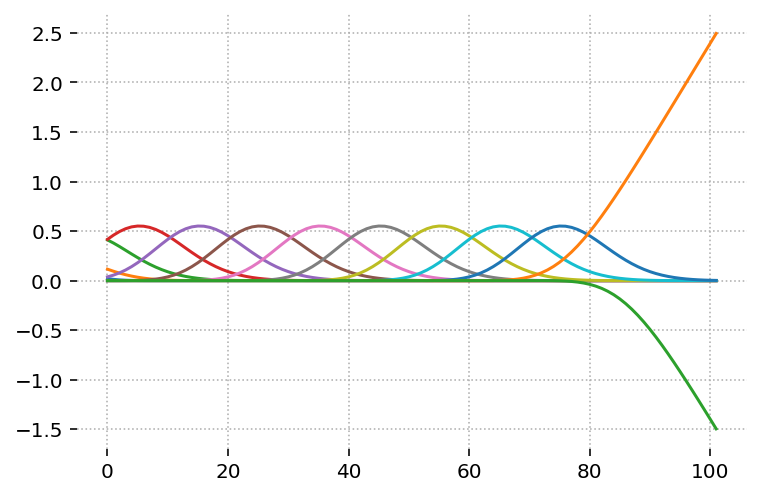

In [1069]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

In [1070]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [1071]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [1072]:
from numpyro.infer import Trace_ELBO

In [1073]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

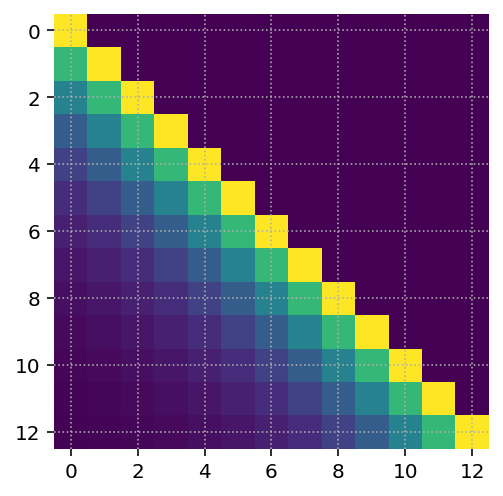

In [1074]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.667
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

In [1075]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)]),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.01,
    b0_scale=0.3,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=100., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':15000, 'lr':0.005, 'lrd': 0.2 ** (1/10000), 'num_samples': 100}

)

In [1076]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 15,000 | 0 %
SVI step 1,000 / 15,000 | 7 %
SVI step 2,000 / 15,000 | 13 %
SVI step 3,000 / 15,000 | 20 %
SVI step 4,000 / 15,000 | 27 %
SVI step 5,000 / 15,000 | 33 %
SVI step 6,000 / 15,000 | 40 %
SVI step 7,000 / 15,000 | 47 %
SVI step 8,000 / 15,000 | 53 %
SVI step 9,000 / 15,000 | 60 %
SVI step 10,000 / 15,000 | 67 %
SVI step 11,000 / 15,000 | 73 %
SVI step 12,000 / 15,000 | 80 %
SVI step 13,000 / 15,000 | 87 %
SVI step 14,000 / 15,000 | 93 %


Text(0, 0.5, 'ELBO')

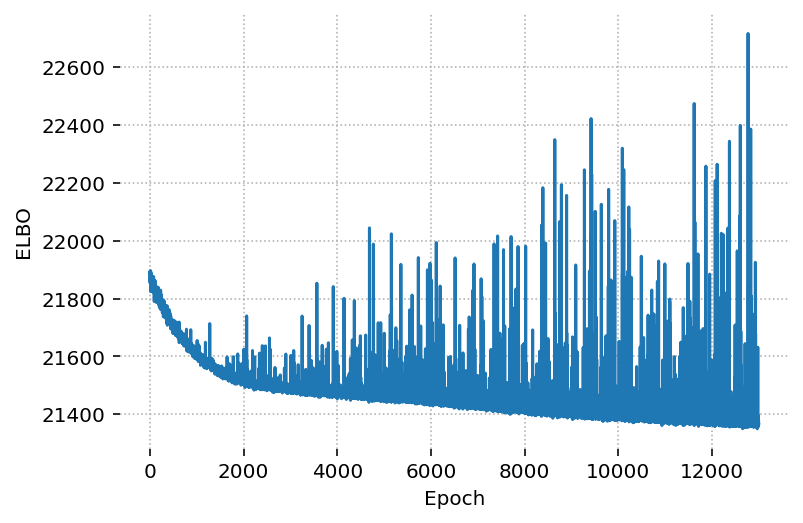

In [1077]:
plt.plot(model.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((None, model.loss[2000]))

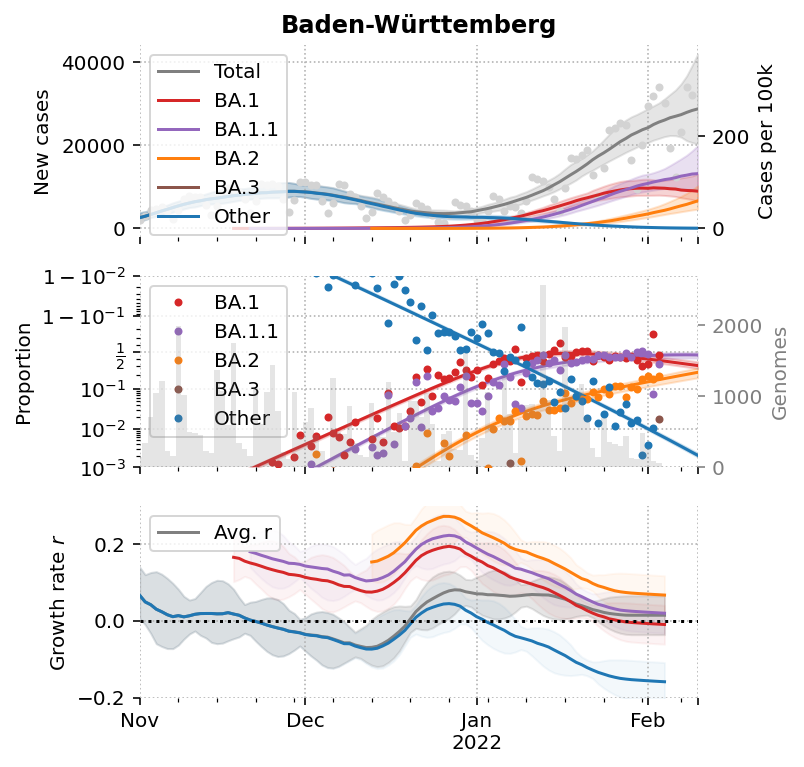

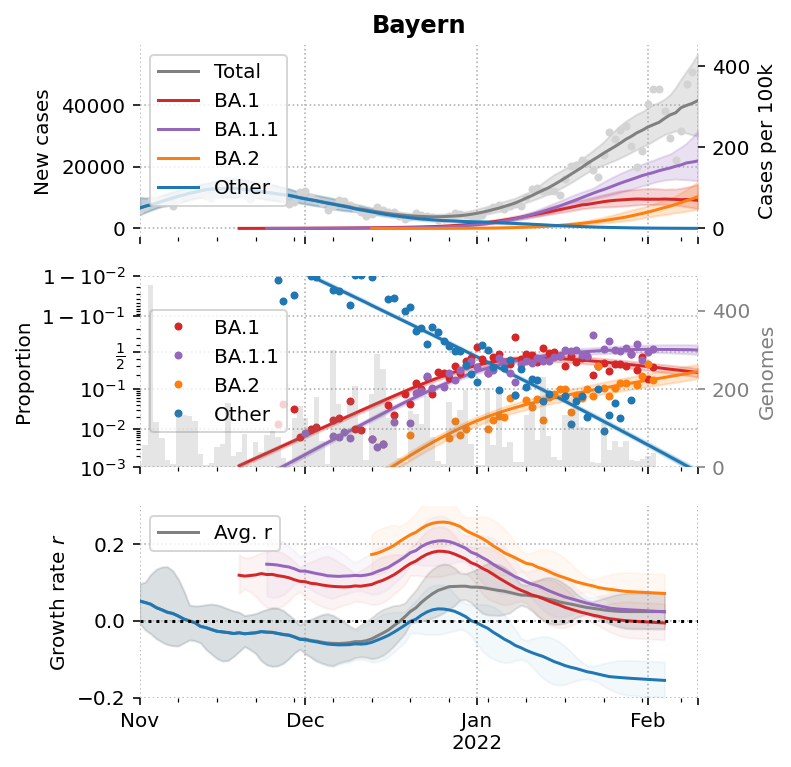

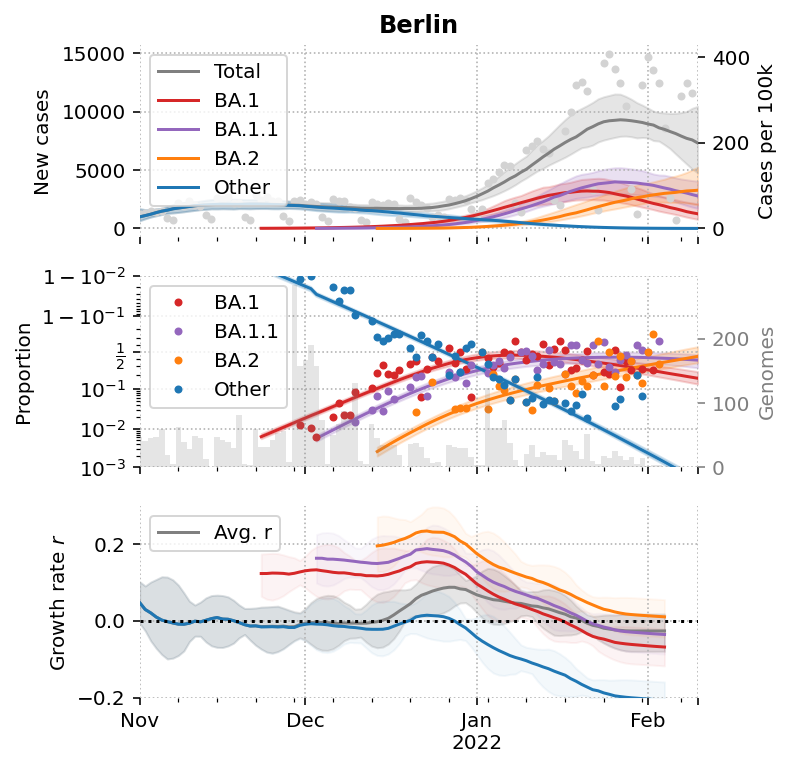

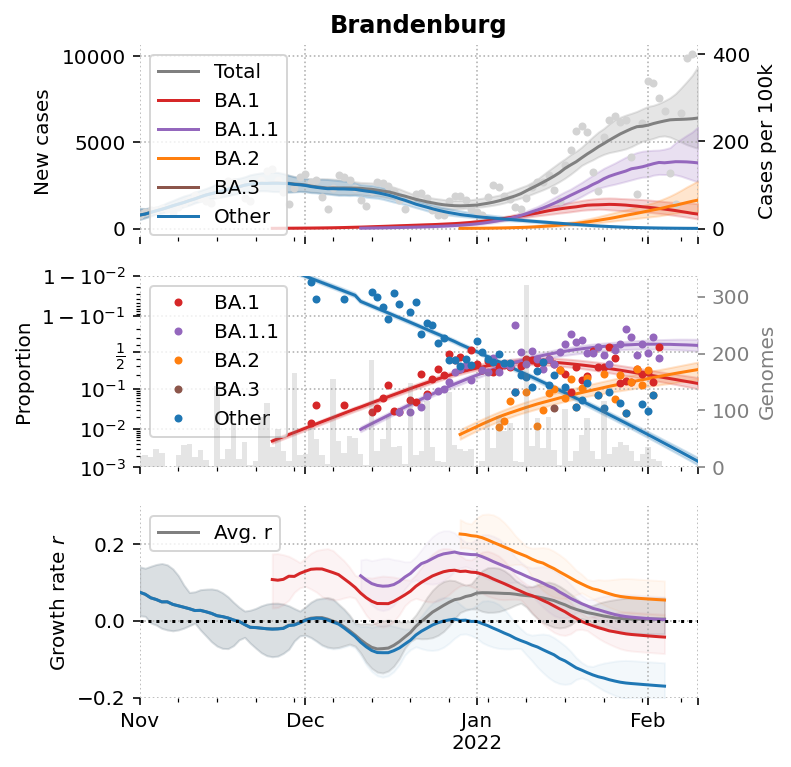

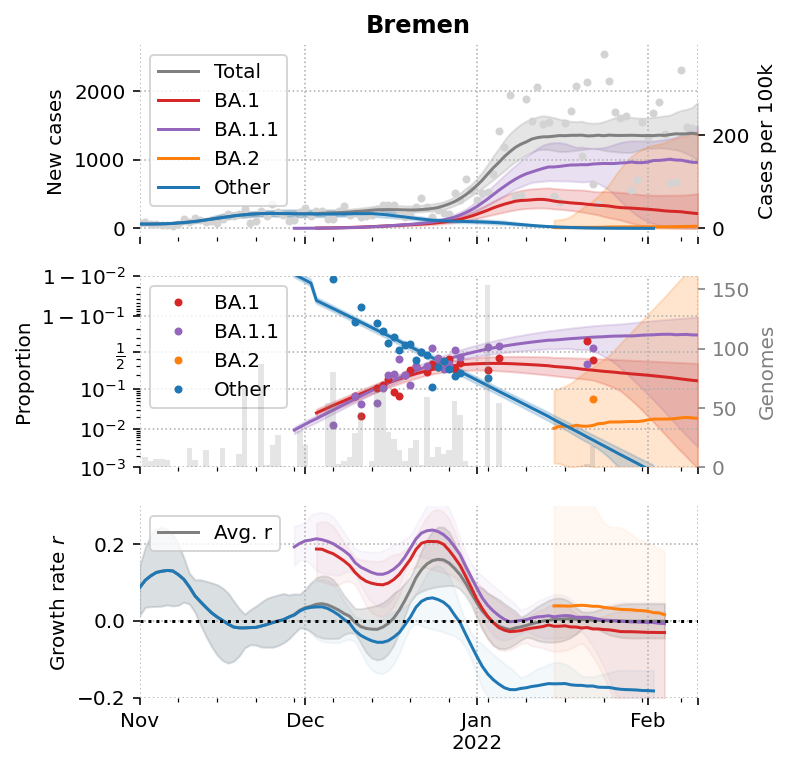

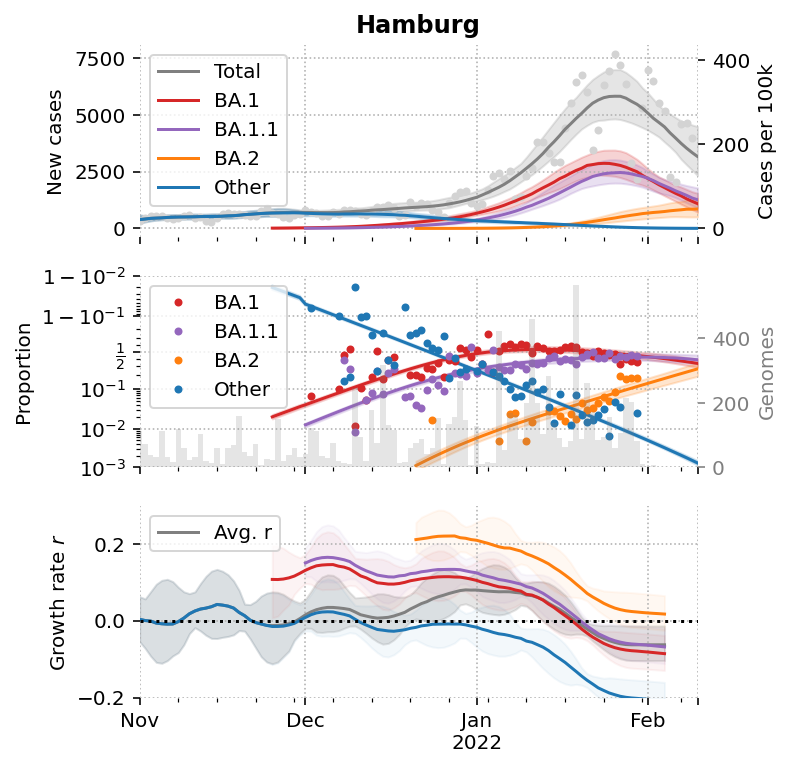

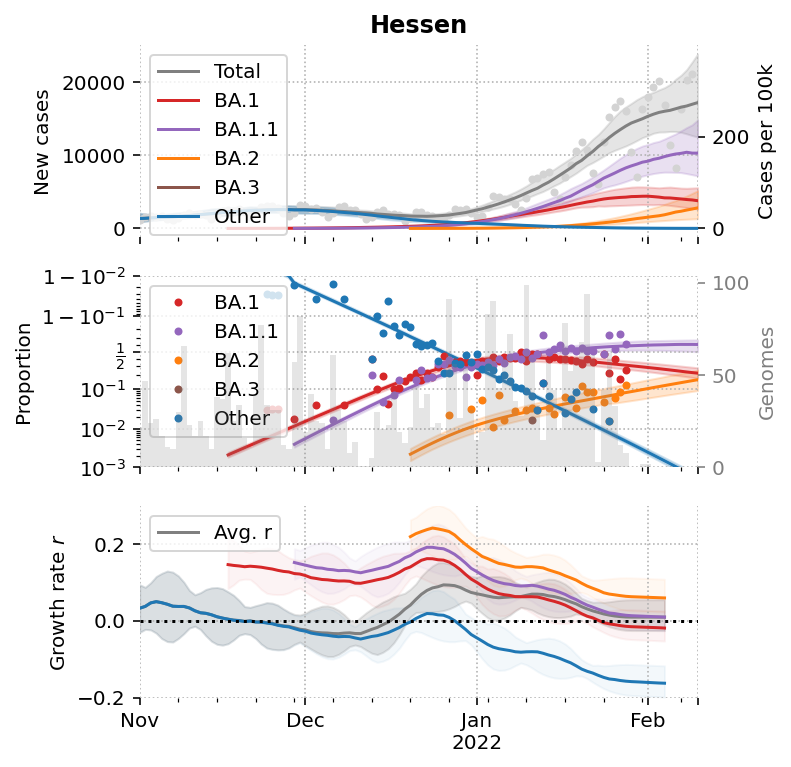

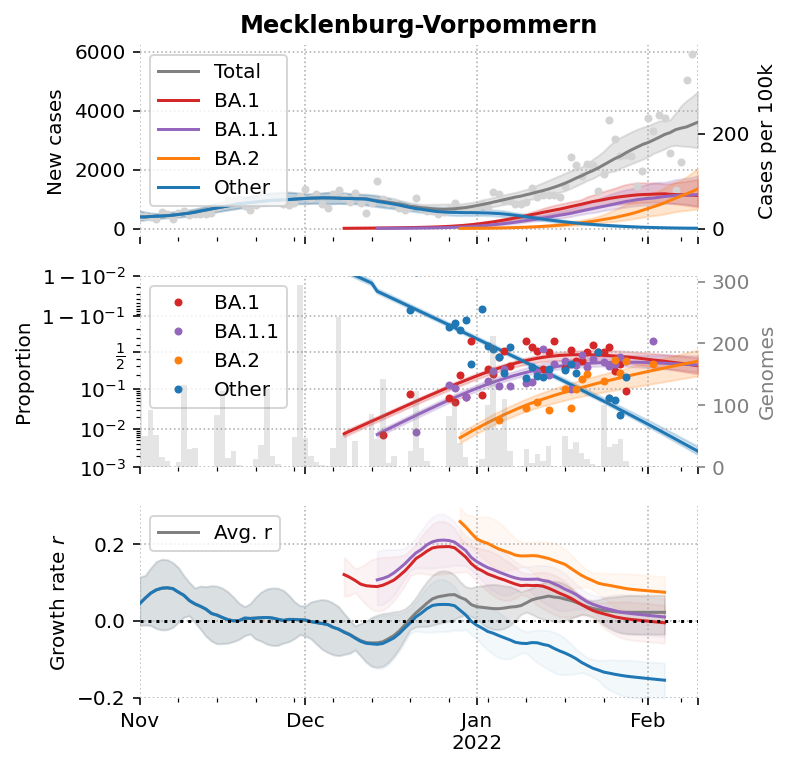

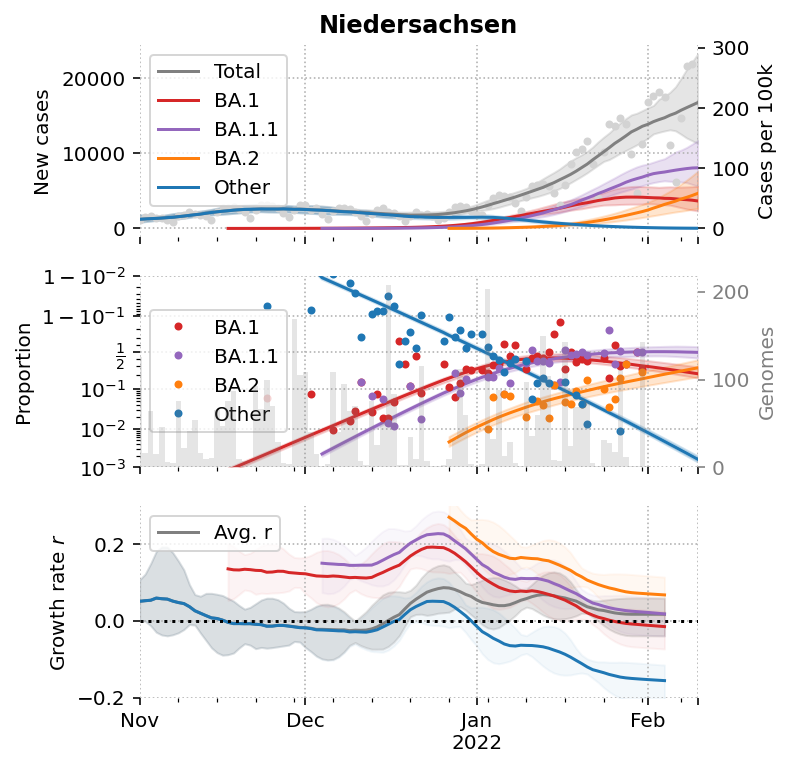

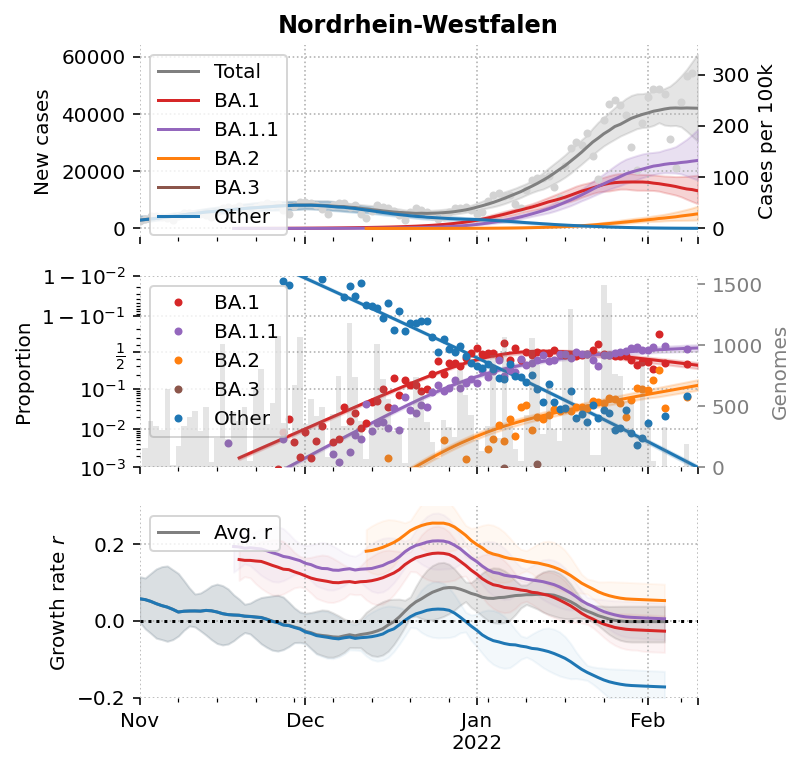

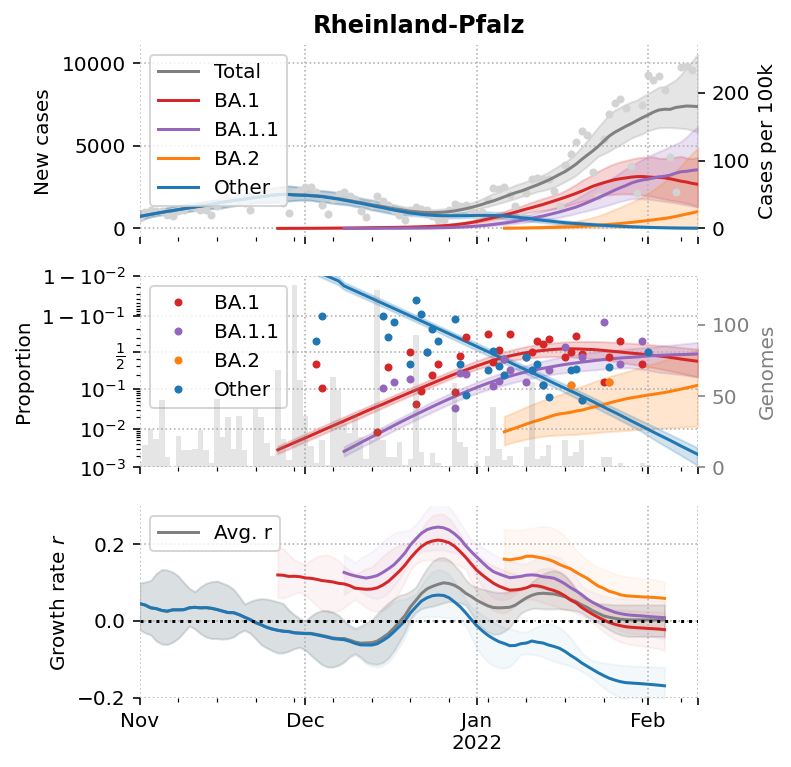

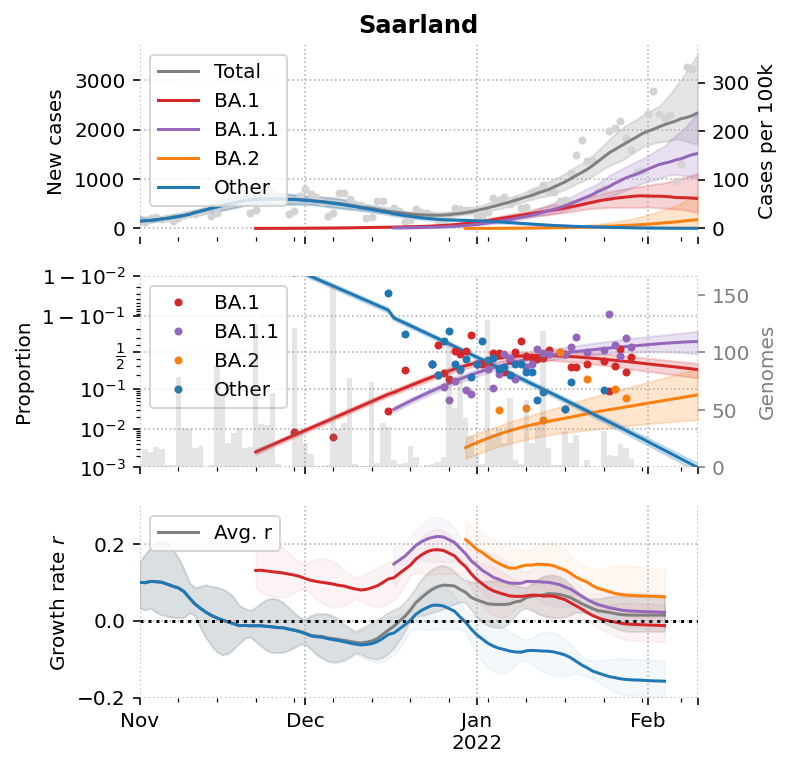

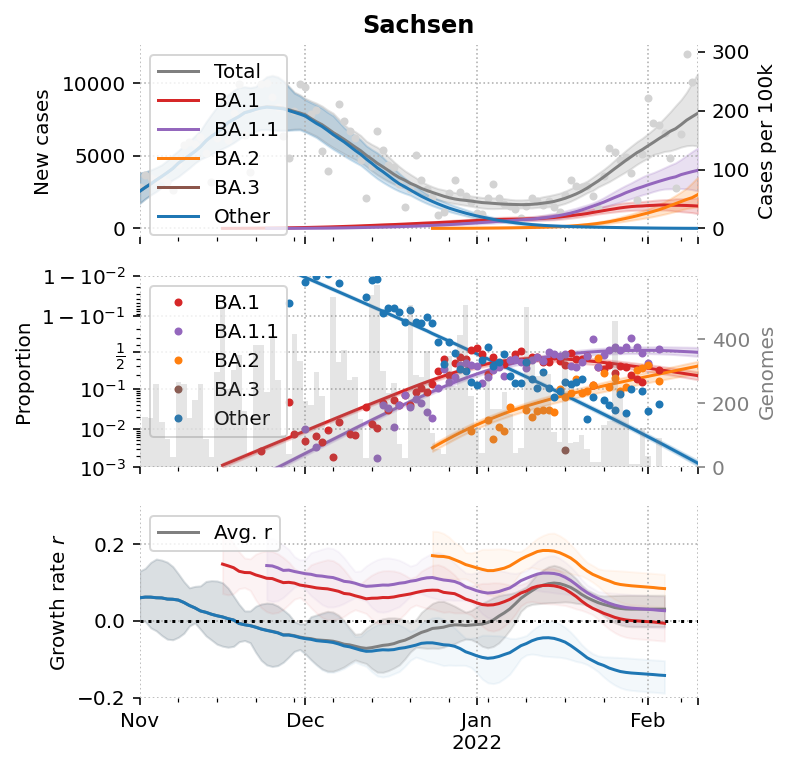

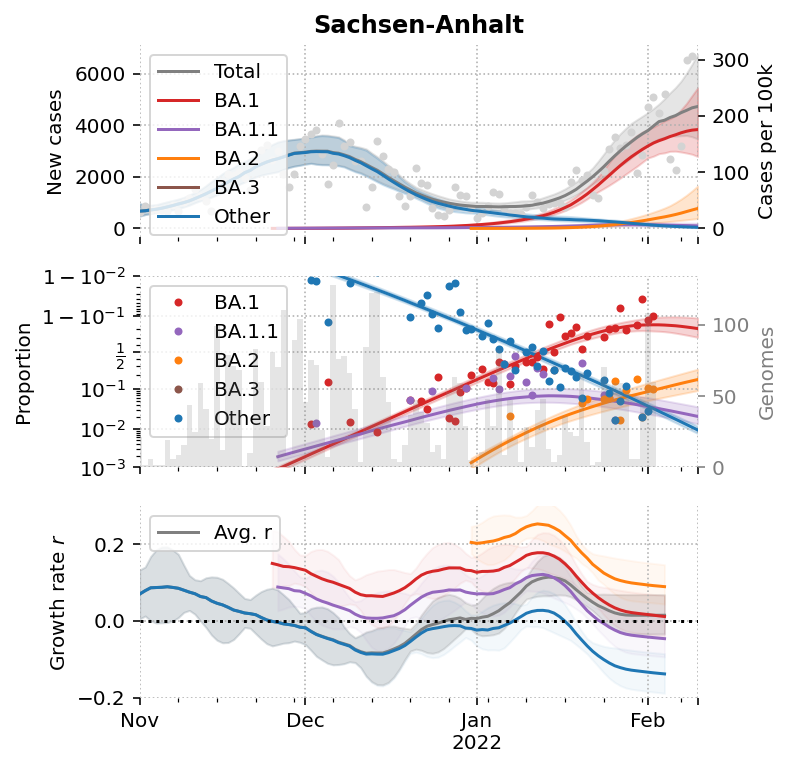

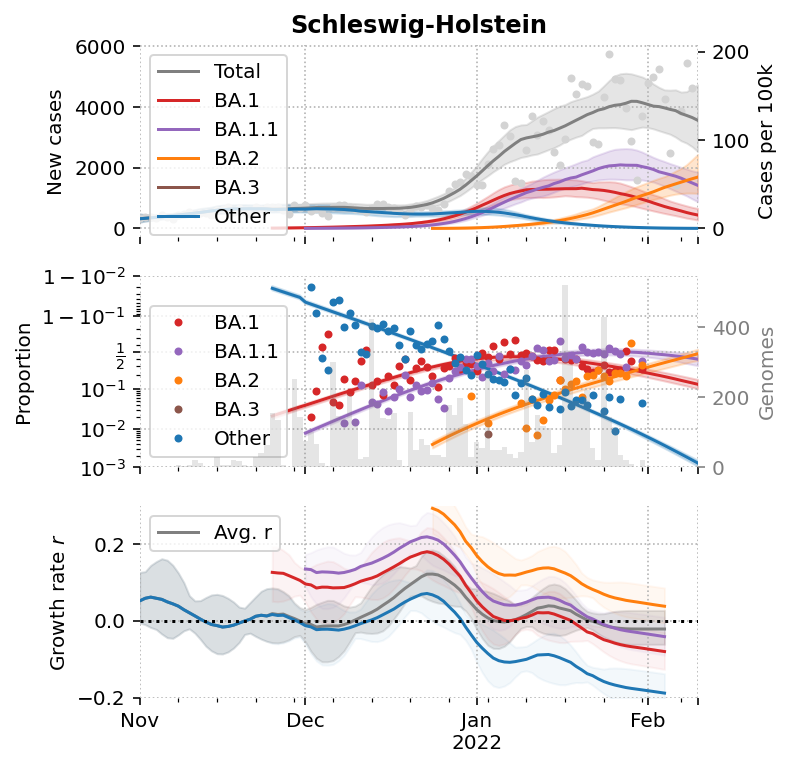

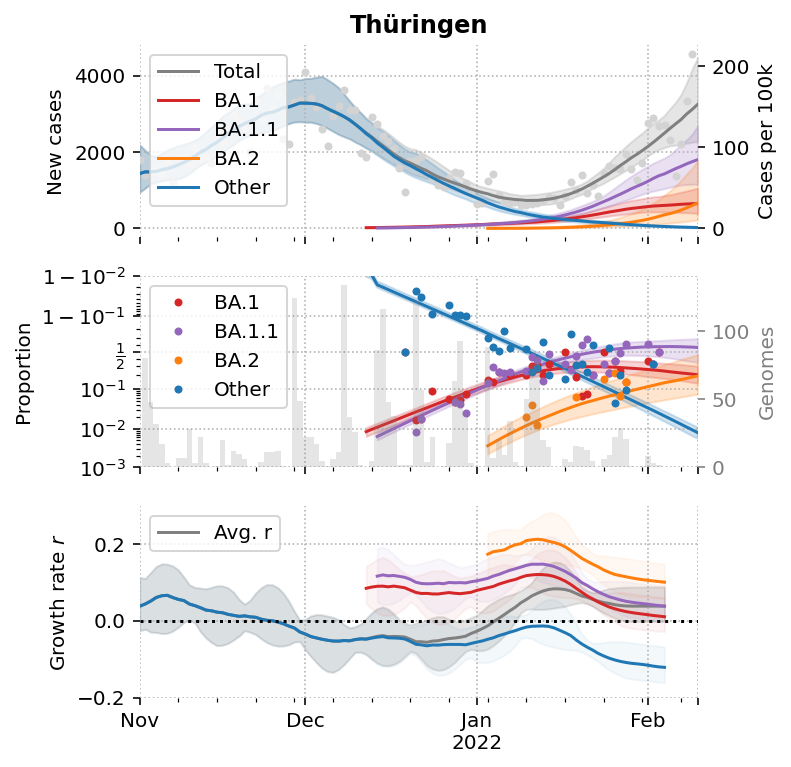

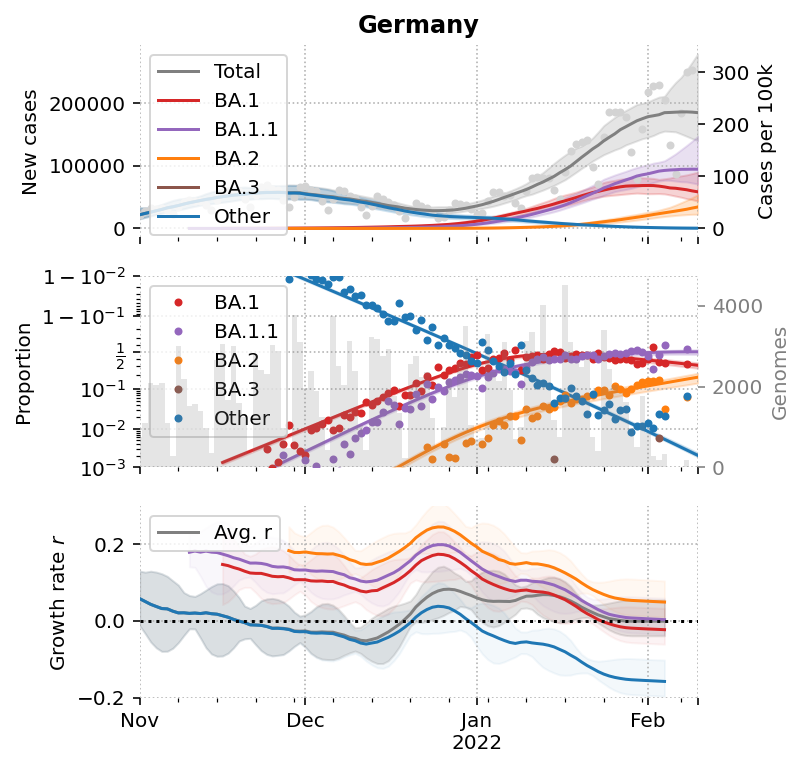

In [1089]:
#from genomicsurveillance.plots.england import plot_lad, 
from genomicsurveillance.plots.england import plot_median_and_ci
for i,r in enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 1)[0]
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = genomes.columns[w],
        lin_colors=np.array(['C3',"C4","C1", "C5" ,"C0", "C9","C0"])[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    #ax[0].set_yscale('log')
    #ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-3,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")

In [1079]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

0.9999999999999999

In [1080]:
model.posterior.keys()

dict_keys(['b1', 'b_scale_lin', 'bc0', 'beta1', 'c1', 't', 'b0'])

Text(0.5, 1.0, 'Germany')

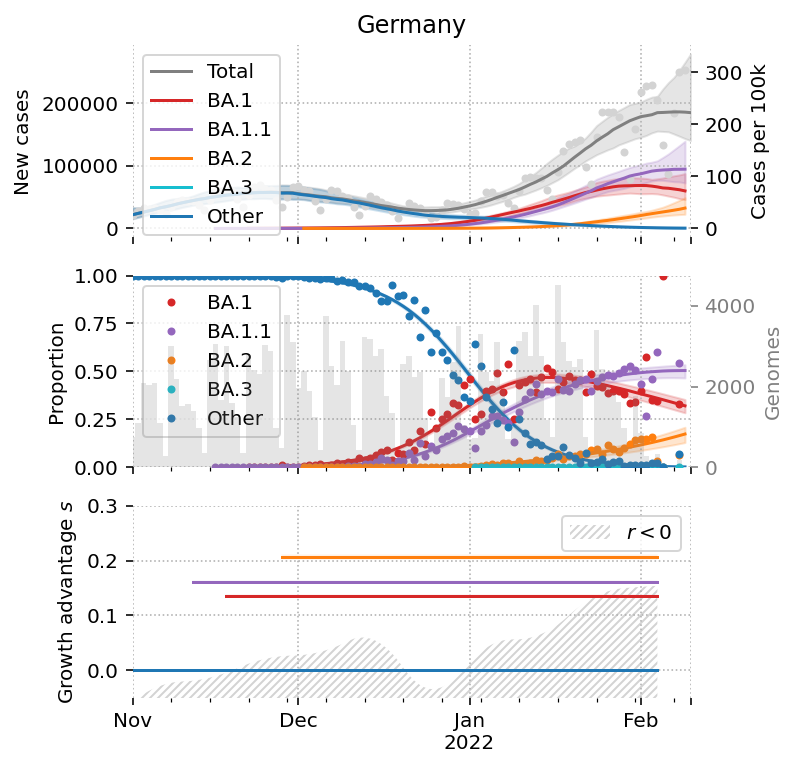

In [1081]:
w = np.arange(genomes.shape[-1])
plot_lad(model, -1, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
            bleed_left = 1,
             bleed_right=6,
             show_Rt = False,
             plot_s= True
            )
plt.gcf().get_axes()[2].set_ylim(-0.05,0.3)
plt.gcf().get_axes()[0].set_title("Germany")

In [1082]:
λ = model.get_lambda_lineage().mean(0) / model.population[:,np.newaxis, np.newaxis]

In [1083]:
λ.shape

(17, 102, 5)

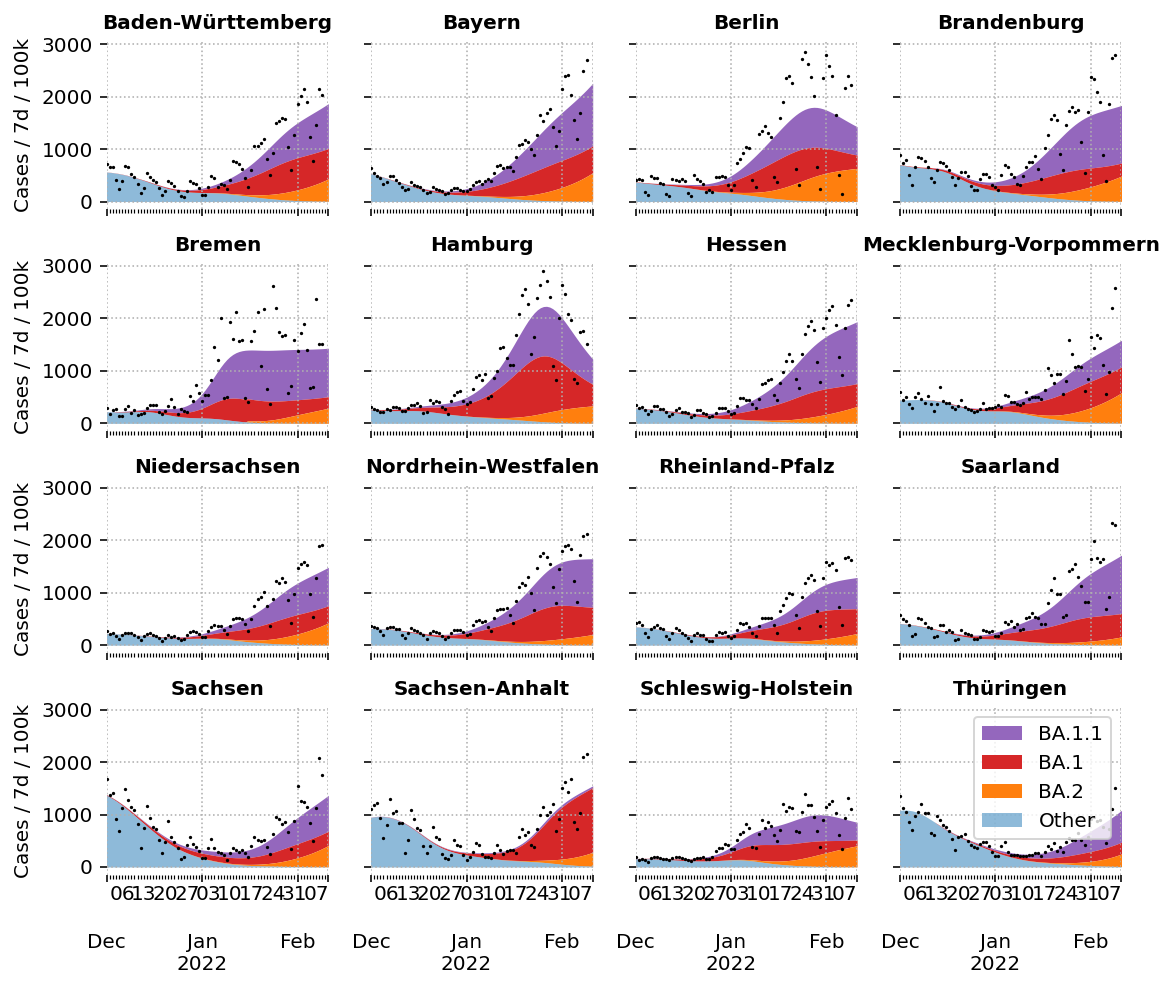

In [1084]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=genomes.columns, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y[["Other","BA.2","BA.1","BA.1.1","BA.3"]].cumsum(1) * 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    (cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    ax[i].fill_between(y.index, y["BA.1"], y["BA.1.1"], color='C4', alpha=1, lw=0, label="BA.1.1")
    ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    ax[i].fill_between(y.index, y["Other"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    ax[i].fill_between(y.index, y["Other"], color='C0', alpha=.5, lw=0, label="Other")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [1085]:
λ.sum((1,2))

array([0.09376172, 0.10613853, 0.11064692, 0.11499555, 0.09609531,
       0.11238073, 0.08588872, 0.08177436, 0.06324841, 0.0835679 ,
       0.0671994 , 0.07901237, 0.11686154, 0.09543092, 0.06255763,
       0.09361332, 0.09010149])

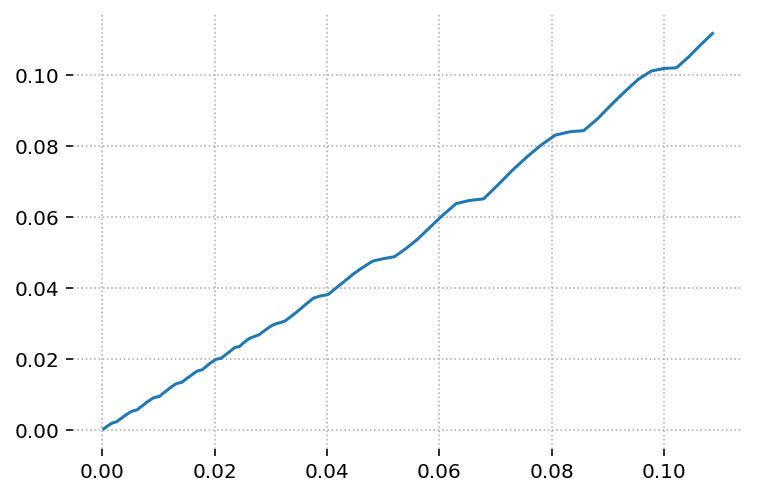

In [1086]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

n  Growth rate r to ancestor      +/-   \
Lineage                                                
BA.1      69096                   0.083211  0.011104   
BA.1.1    57360                   0.097991  0.020811   
BA.2       6934                   0.181568  0.005347   
BA.3         22                  -0.073293  0.036790   
Other    236872                   0.000000  0.000000   

         Growth rate r to baseline BA.1       +/-  
Lineage                                            
BA.1                           0.000000  0.011104  
BA.1.1                         0.024949  0.020811  
BA.2                           0.083903  0.005347  
BA.3                          -0.236882  0.036790  
Other                         -0.139614  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:875: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


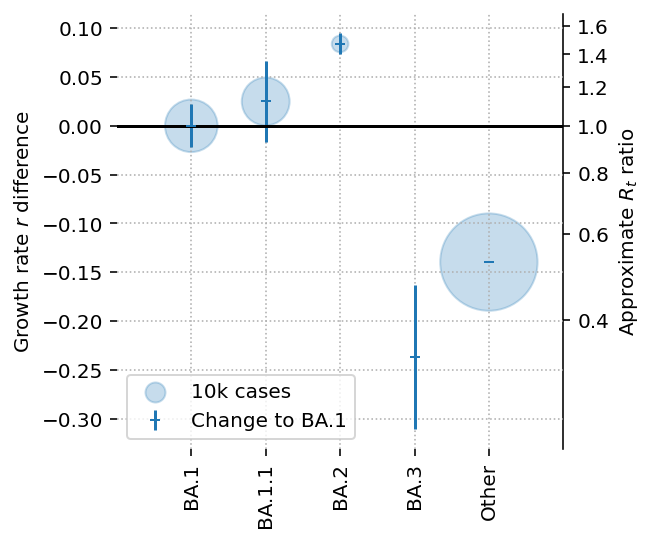

In [1087]:
plt.figure(figsize=(4,4))
plot_growth_rates(model, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")

In [1036]:
import geopandas as gpd

In [1037]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [1038]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [1039]:
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other
bundesland        date                                       
Baden-Württemberg 2021-11-01     0       0     0     0    142
                  2021-11-02     0       0     0     0    350
                  2021-11-03     0       0     0     0    704
                  2021-11-04     0       0     0     0   1044
                  2021-11-05     0       0     0     0   1210
...                            ...     ...   ...   ...    ...
Thüringen         2022-02-02     1       1     0     0      1
                  2022-02-03     1       1     0     0      0
                  2022-02-04     0       0     0     0      0
                  2022-02-05     0       0     0     0      0
                  2022-02-08     0       0     0     0      0

[1568 rows x 5 columns]

In [1040]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([0.28308316, 0.48709611, 0.22523837, 0.00221679, 0.00236557])

In [1041]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


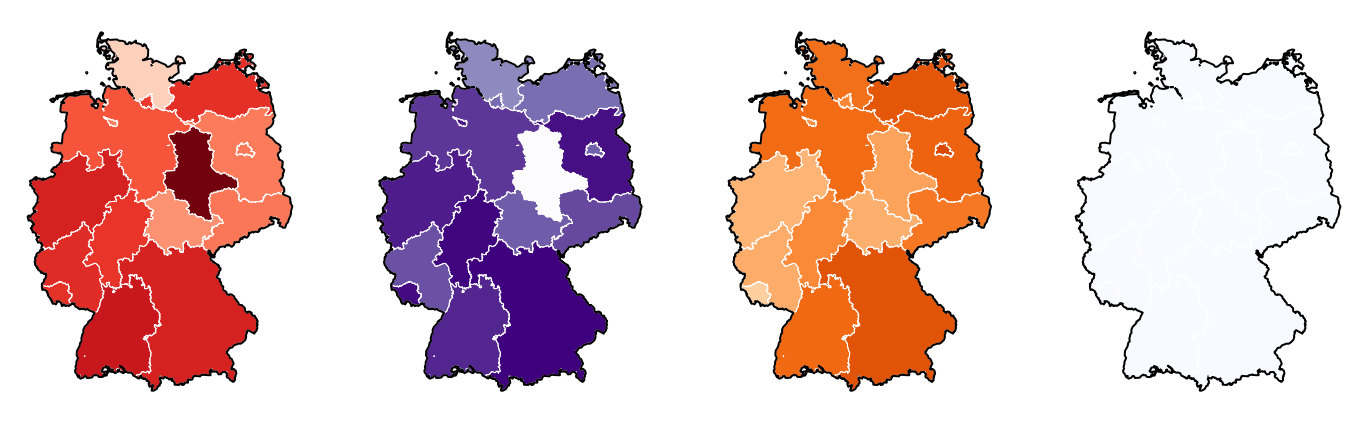

In [1042]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,4, figsize=(12,6))
for ax in axs:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:], columns=genomes.columns, index=bl.index), 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="Reds", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
for ax in axs:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [1128]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-0.0112931 ,  0.0181705 ,  0.06680951, -0.29153241, -0.1598512 ],
       [-0.00541905,  0.02219668,  0.07075302, -0.1560507 , -0.1560507 ],
       [-0.07029669, -0.03785995,  0.00915401, -0.2096501 , -0.2096501 ],
       [-0.04332605,  0.00263758,  0.05273179, -0.32168878, -0.17125928],
       [-0.06127803, -0.03458369, -0.00141332, -0.21201586, -0.21201586],
       [-0.08777917, -0.06904768,  0.01663944, -0.21036245, -0.21036245],
       [-0.02453599,  0.00405005,  0.05298724, -0.32947525, -0.16816186],
       [-0.00900135,  0.00739312,  0.06810855, -0.1595246 , -0.1595246 ],
       [-0.01977785,  0.01289845,  0.06607809, -0.16075568, -0.16075568],
       [-0.02978471,  0.00286089,  0.04881905, -0.25928219, -0.17545785],
       [-0.02548735,  0.00615338,  0.0519841 , -0.17018847, -0.17018847],
       [-0.01224567,  0.02223193,  0.06481478, -0.15653202, -0.15653202],
       [-0.00891726,  0.02311021,  0.08053691, -0.24417163, -0.14609275],
       [ 0.00997581, -0.04801671,  0.0

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


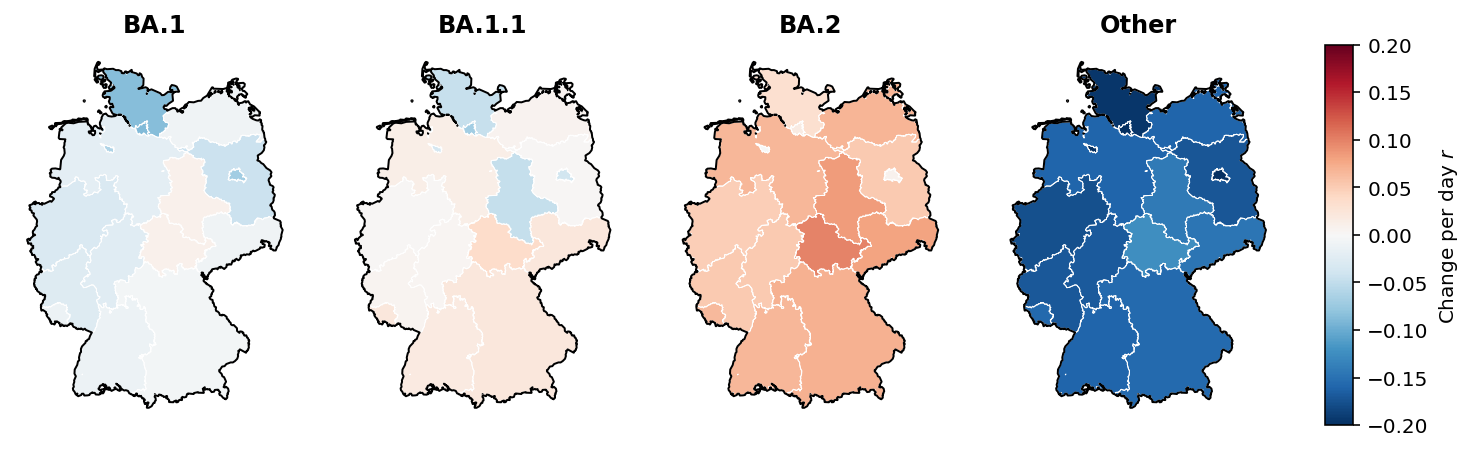

In [1143]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [1127]:
d

lineage                     BA.1    BA.1.1      BA.2      BA.3     Other
bundesland                                                              
Baden-Württemberg      -0.011293  0.018171  0.066810 -0.291532 -0.159851
Bayern                 -0.005419  0.022197  0.070753 -0.156051 -0.156051
Berlin                 -0.070297 -0.037860  0.009154 -0.209650 -0.209650
Brandenburg            -0.043326  0.002638  0.052732 -0.321689 -0.171259
Bremen                 -0.061278 -0.034584 -0.001413 -0.212016 -0.212016
Hamburg                -0.087779 -0.069048  0.016639 -0.210362 -0.210362
Hessen                 -0.024536  0.004050  0.052987 -0.329475 -0.168162
Mecklenburg-Vorpommern -0.009001  0.007393  0.068109 -0.159525 -0.159525
Niedersachsen          -0.019778  0.012898  0.066078 -0.160756 -0.160756
Nordrhein-Westfalen    -0.029785  0.002861  0.048819 -0.259282 -0.175458
Rheinland-Pfalz        -0.025487  0.006153  0.051984 -0.170188 -0.170188
Saarland               -0.012246  0.022232  0.064815 -0.156532 -0.156532
Sachsen                -0.008917  0.023110  0.080537 -0.244172 -0.146093
Sachsen-Anhalt               NaN       NaN       NaN       NaN       NaN
Schleswig-Holstein     -0.084834 -0.045748  0.032176 -0.275626 -0.194002
Thüringen               0.009612  0.036373  0.099825 -0.123930 -0.123930

In [115]:
genomes.loc["Rheinland-Pfalz","2022-01-01":,:]

lineage                     BA.1.1  BA.1  BA.2  BA.3  Other
bundesland      date                                       
Rheinland-Pfalz 2022-01-01       0     0     0     0      0
                2022-01-02       0     0     0     0      0
                2022-01-03       0     2     0     0      0
                2022-01-04       0     5     0     0     22
                2022-01-05       0     0     0     0      2
                2022-01-06       0     0     0     0      0
                2022-01-07       0     0     0     0      0
                2022-01-08       0     0     0     0      1
                2022-01-09       0     0     0     0      0
                2022-01-10       0     1     0     0      0
                2022-01-11       0     0     0     0      0
                2022-01-12       0     0     0     0      1
                2022-01-13       0     0     1     0      0
                2022-01-14       0     1     0     0      0
                2022-01-15       0     0     0     0      0
                2022-01-16       0     0     0     0      0
                2022-01-17       0     0     0     0      0
                2022-01-18       0     0     0     0      0
                2022-01-19       0     0     0     0      0
                2022-01-20       0     0     0     0      0
                2022-01-21       0     0     0     0      0
                2022-01-22       0     0     0     0      0
                2022-01-23       0     0     0     0      0
                2022-01-24       0     0     0     0      0
                2022-01-25       0     0     0     0      0
                2022-01-26       0     0     0     0      0

In [116]:
capita.values @ λ[:-1,-1,:]

array([103657.00267258,  93567.99171471,  33828.39373456,   2451.61090274,
         2537.43408102])

In [117]:
(lambda x: x/x.sum(1, keepdims=True))(λ[:,-1,:])

array([[3.73842094e-01, 4.83283873e-01, 1.33117836e-01, 3.30964237e-04,
        9.42523237e-03],
       [4.77723939e-01, 3.35254227e-01, 1.39716323e-01, 4.15601022e-02,
        5.74540875e-03],
       [4.01464060e-01, 4.07470469e-01, 1.87871681e-01, 0.00000000e+00,
        3.19378948e-03],
       [5.16355308e-01, 2.52204762e-01, 2.16802558e-01, 0.00000000e+00,
        1.46373722e-02],
       [7.22478992e-01, 2.75944111e-01, 0.00000000e+00, 0.00000000e+00,
        1.57689784e-03],
       [4.28577408e-01, 4.78027912e-01, 8.83935204e-02, 1.05578645e-03,
        3.94537308e-03],
       [4.44808166e-01, 5.04272585e-01, 4.48851588e-02, 0.00000000e+00,
        6.03409002e-03],
       [3.73161598e-01, 4.05635770e-01, 2.02118520e-01, 0.00000000e+00,
        1.90841114e-02],
       [5.25826950e-01, 2.85654231e-01, 1.76409820e-01, 0.00000000e+00,
        1.21089989e-02],
       [4.64662618e-01, 4.26984320e-01, 1.02916846e-01, 7.25359139e-04,
        4.71085669e-03],
       [2.41412714e-02, 3.3769

In [118]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


In [ ]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]
r = colors.colorConverter.to_rgb("C3")
b = colors.colorConverter.to_rgb("C0")
y = colors.colorConverter.to_rgb("C1")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[1,2,4]]/λ.max()
    c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [ ]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

In [ ]:
λ.max()*700

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[1,2,4]]/λ.max()
    c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,4] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,1] @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


In [ ]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [ ]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [968]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [969]:
cases_uk

date
2021-11-01    45068
2021-11-02    37982
2021-11-03    35934
2021-11-04    33618
2021-11-05    30294
              ...  
2022-02-03    72748
2022-02-04    60020
2022-02-05    49005
2022-02-06    56290
2022-02-07    68548
Name: newCasesBySpecimenDate, Length: 99, dtype: int64

In [970]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          284897.0
BA.1.1         90454.0
BA.2            7667.0
BA.3              11.0
B.1.617.2*    364518.0
dtype: float64

In [971]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [972]:
genomes_uk

BA.1  BA.1.1   BA.2  BA.3  B.1.617.2*
date                                               
2021-11-01     0.0     0.0    0.0   0.0      7615.0
2021-11-02     0.0     0.0    0.0   0.0      5970.0
2021-11-03     1.0     0.0    0.0   0.0      7019.0
2021-11-04     0.0     0.0    0.0   0.0      6382.0
2021-11-05     0.0     0.0    0.0   0.0      6839.0
...            ...     ...    ...   ...         ...
2022-01-29  2817.0  2403.0  573.0   0.0         2.0
2022-01-30  2986.0  2613.0  706.0   0.0         0.0
2022-01-31  3123.0  2750.0  710.0   0.0         4.0
2022-02-01   942.0   868.0  275.0   0.0         2.0
2022-02-02   368.0   393.0  166.0   0.0         1.0

[94 rows x 5 columns]

In [973]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [976]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [977]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [978]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [984]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':10000, 'lr':0.05, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [985]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

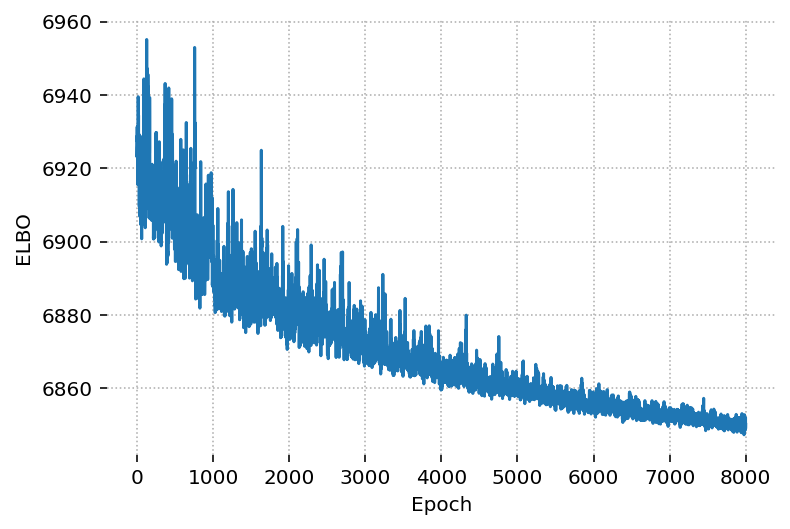

In [986]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [987]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

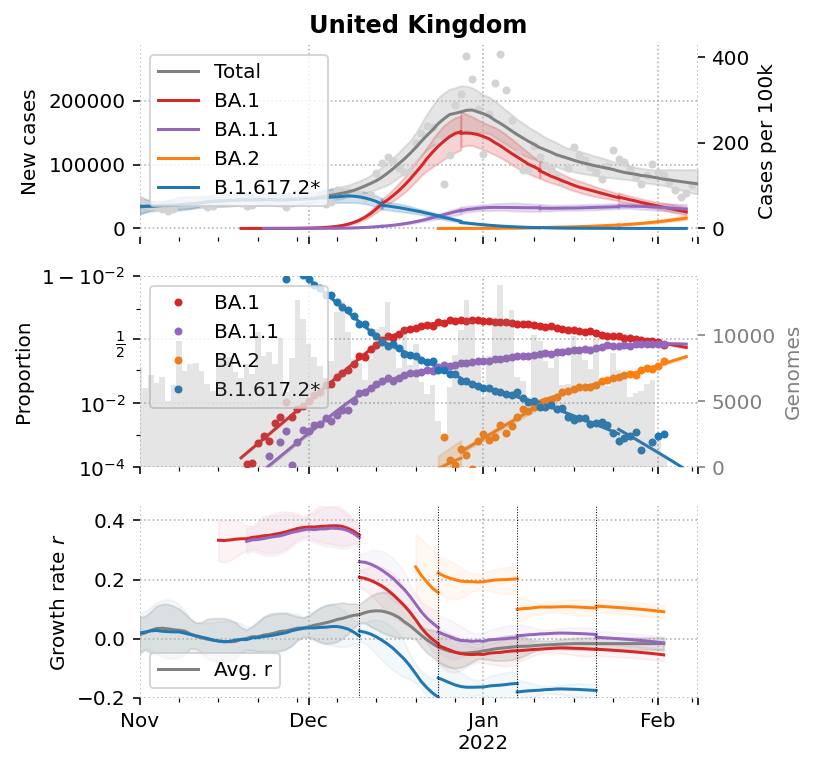

In [990]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             #plot_s= True,
             #plot_r = False
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [665]:
ax[2].xaxis.

In [991]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

n  Growth rate r to ancestor      +/-   \
Lineage                                                   
BA.1        284879                   0.082607  0.080054   
BA.1.1       90443                   0.071844  0.060181   
BA.2          7662                   0.203139  0.033393   
BA.3            11                   0.009134  0.088925   
B.1.617.2*  364518                   0.000000  0.000000   

            Growth rate r to baseline BA.1       +/-  
Lineage                                               
BA.1                              0.000000  0.080054  
BA.1.1                            0.036203  0.060181  
BA.2                              0.141224  0.033393  
BA.3                             -0.133910  0.088925  
B.1.617.2*                       -0.196245  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:875: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


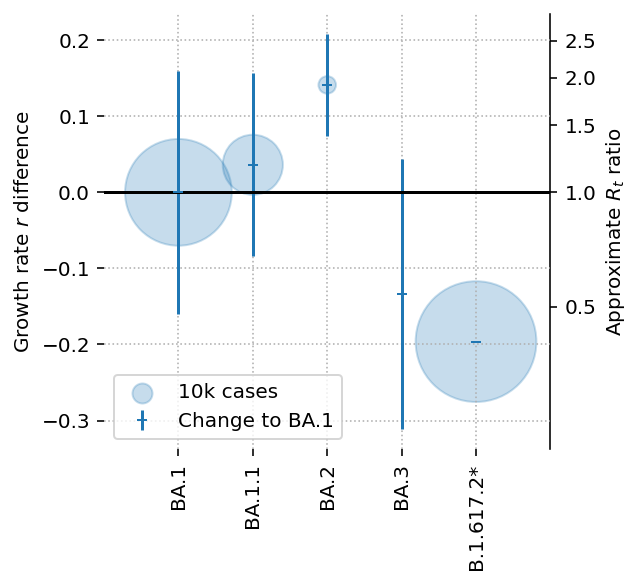

In [992]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [73]:
bar.shape

(4, 88, 5)

In [70]:
ax=plt.gcf().get_axes()

<Figure size 432x288 with 0 Axes>

In [71]:
ax

[]

## Germany

In [573]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [574]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [575]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

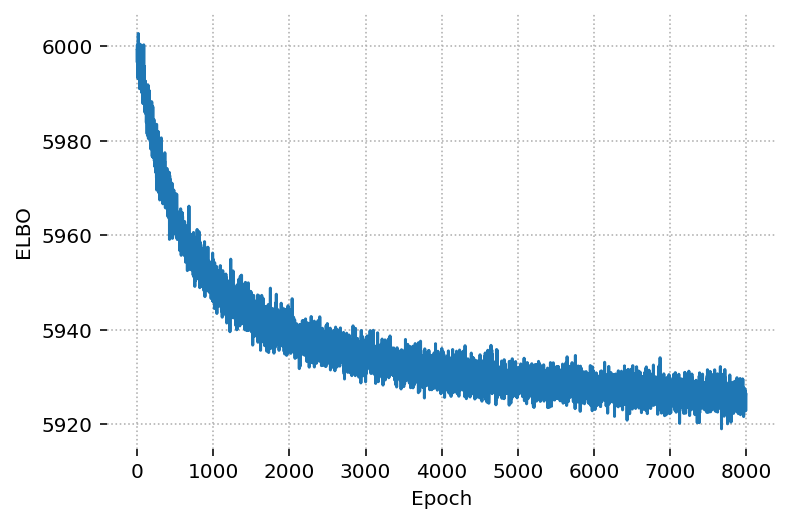

In [576]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [593]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

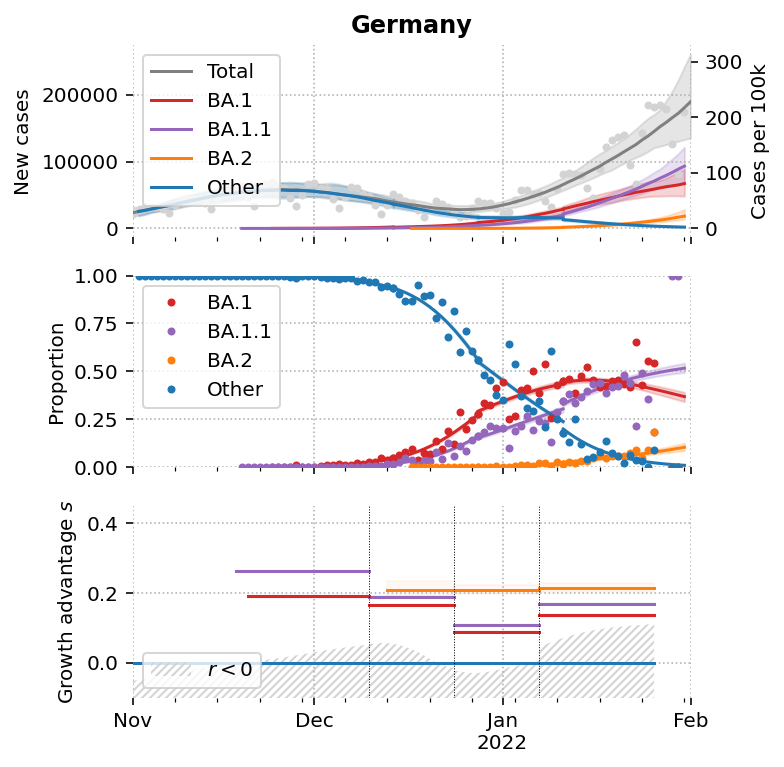

In [644]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,4]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



n  Growth rate r to ancestor      +/-   \
Lineage                                                
BA.1.1    20392                   0.027830  0.055461   
BA.1      29810                   0.018269  0.038403   
BA.2       1342                   0.052132  0.006506   
BA.3         34                   0.023450  0.150064   
Other    134312                   0.000000  0.000000   

         Growth rate r to baseline BA.1       +/-  
Lineage                                            
BA.1.1                         0.037203  0.055461  
BA.1                           0.000000  0.038403  
BA.2                           0.066860  0.006506  
BA.3                          -0.117794  0.150064  
Other                         -0.144801  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:874: RuntimeWarning: divide by zero encountered in log
  plt.axhline(0, c="k")


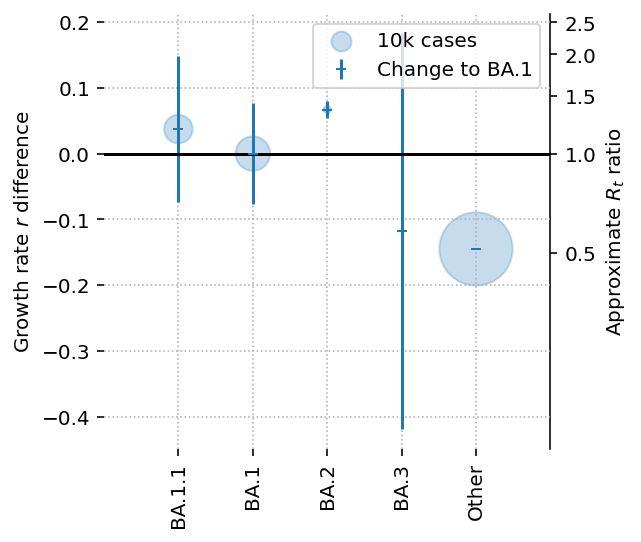

In [635]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [365]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [366]:
cases_dk

Dato
2021-11-01     2191
2021-11-02     2313
2021-11-03     2295
2021-11-04     2340
2021-11-05     2205
              ...  
2022-01-26    41724
2022-01-27    39088
2022-01-28    35946
2022-01-29    28186
2022-01-30    12808
Name: Bekræftede tilfælde, Length: 91, dtype: int64

In [367]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

BA.1          27372.0
BA.1.1         2779.0
BA.2          20130.0
B.1.617.2*    81370.0
dtype: float64

In [409]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [410]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [411]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [412]:
foo.shape

(4, 91)

In [413]:
model_dk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 12,000 | 0 %
SVI step 1,000 / 12,000 | 8 %
SVI step 2,000 / 12,000 | 17 %
SVI step 3,000 / 12,000 | 25 %
SVI step 4,000 / 12,000 | 33 %
SVI step 5,000 / 12,000 | 42 %
SVI step 6,000 / 12,000 | 50 %
SVI step 7,000 / 12,000 | 58 %
SVI step 8,000 / 12,000 | 67 %
SVI step 9,000 / 12,000 | 75 %
SVI step 10,000 / 12,000 | 83 %
SVI step 11,000 / 12,000 | 92 %


Text(0, 0.5, 'ELBO')

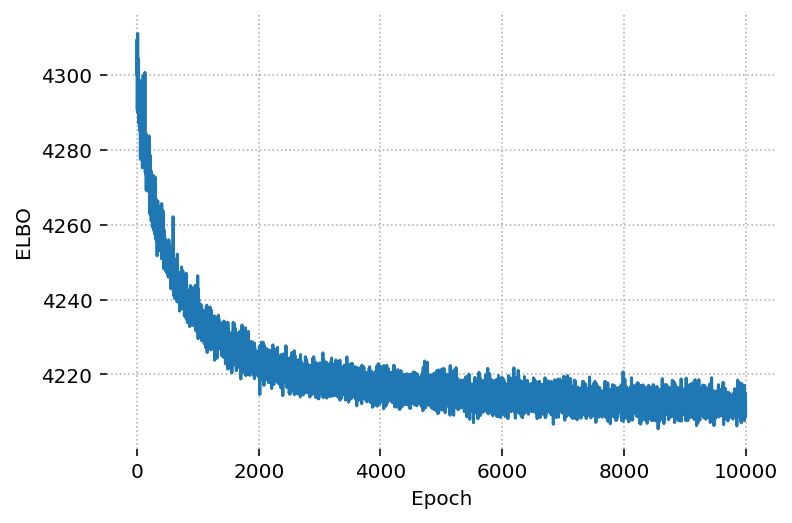

In [414]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [626]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

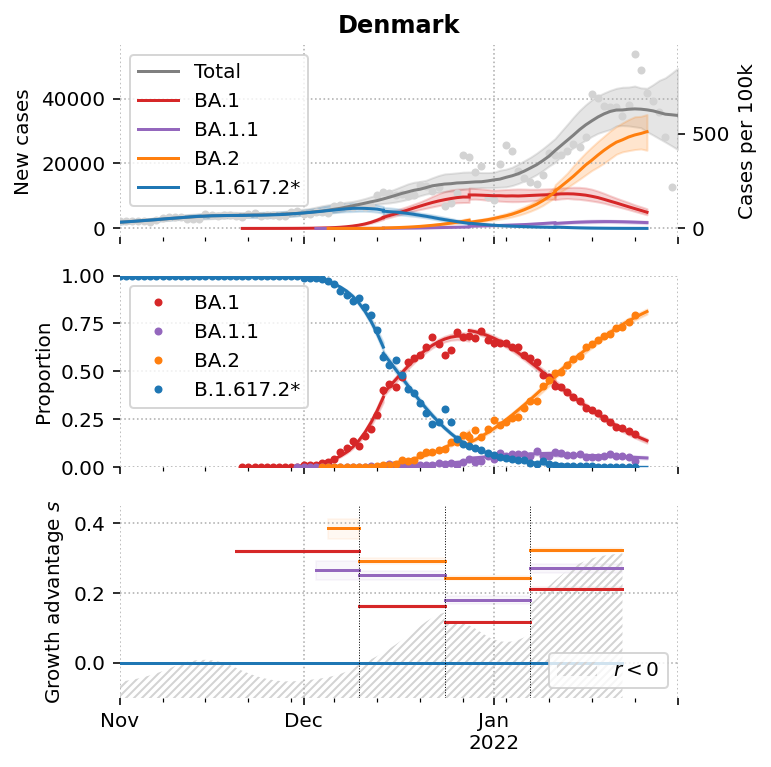

In [647]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [428]:
(bar[-1,-15:] )

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [6.890e+02, 1.210e+02, 8.140e+02, 1.400e+01],
       [7.870e+02, 1.250e+02, 1.064e+03, 1.800e+01],
       [7.440e+02, 1.260e+02, 1.155e+03, 1.100e+01],
       [5.490e+02, 1.100e+02, 9.180e+02, 8.000e+00],
       [4.300e+02, 7.600e+01, 8.650e+02, 7.000e+00],
       [6.010e+02, 1.080e+02, 1.303e+03, 1.000e+01],
       [6.290e+02, 1.200e+02, 1.481e+03, 8.000e+00],
       [4.950e+02, 1.110e+02, 1.325e+03, 5.000e+00],
       [3.900e+02, 1.160e+02, 1.155e+03, 3.000e+00],
       [4.050e+02, 1.120e+02, 1.390e+03, 3.000e+00],
       [3.260e+02, 9.800e+01, 1.167e+03, 4.000e+00],
       [9.200e+01, 2.600e+01, 3.700e+02, 1.000e+00],
       [4.500e+01, 8.000e+00, 2.040e+02, 0.000e+00]])

In [209]:
genomes_dk

BA.1  BA.1.1    BA.2  B.1.617.2*
date                                         
2021-11-01    0.0     0.0     0.0      1232.0
2021-11-02    0.0     0.0     0.0      1605.0
2021-11-03    0.0     0.0     0.0      1760.0
2021-11-04    0.0     0.0     0.0      1540.0
2021-11-05    0.0     0.0     0.0      1641.0
...           ...     ...     ...         ...
2022-01-20  390.0   116.0  1155.0         3.0
2022-01-21  405.0   112.0  1390.0         3.0
2022-01-22  326.0    98.0  1167.0         4.0
2022-01-23   92.0    26.0   370.0         1.0
2022-01-24   45.0     8.0   204.0         0.0

[85 rows x 4 columns]

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        27372                   0.036938  0.074269   
BA.1.1       2779                   0.052333  0.019801   
BA.2        20130                   0.037401  0.020701   
B.1.617.2*  81370                   0.000000  0.000000   

            Growth rate r to baseline BA.1       +/-  
Lineage                                               
BA.1                              0.000000  0.074269  
BA.1.1                            0.023355  0.019801  
BA.2                              0.086703  0.020701  
B.1.617.2*                       -0.186289  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:868: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


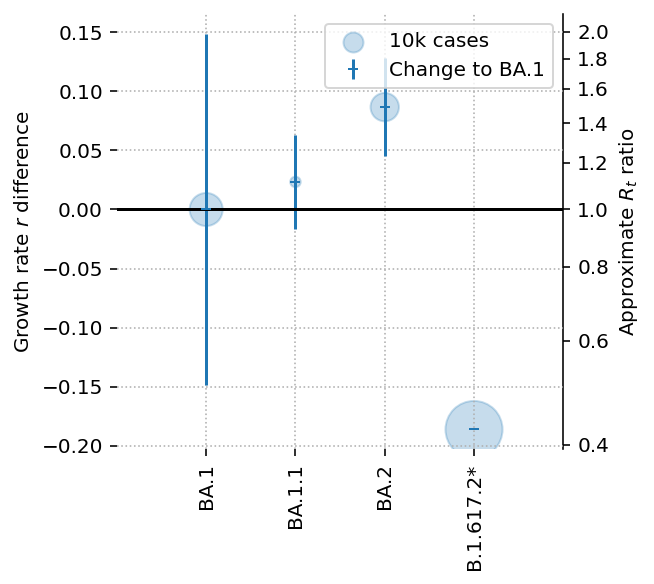

In [215]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
